In [1]:
import numpy as np
import scipy
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="white", palette="muted")
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
dt = 0.001
k = 3.14
m = 1
n = 1000

In [3]:
M = np.array([
    [   0, 1, 0],
    [-k/m, 0, 1],
    [   0, 0, 0]
])
Md = scipy.linalg.expm(M*dt)
Ad = Md[:2, :2]
Bd = Md[:2, 2:]
Cd = np.array([
    [1, 0]
])
Dd = np.zeros((1, 1))
print('continuous state space:')
print('A')
print(M[:2, :2])
print('B')
print(M[:2, 2:])
print('C')
print(Cd)
print('D')
print(Dd)
print()
print('discrete time state space, dt = {}'.format(dt))
print('Ad')
print(Ad)
print('Bd')
print(Bd)

continuous state space:
A
[[ 0.    1.  ]
 [-3.14  0.  ]]
B
[[ 0.]
 [ 1.]]
C
[[1 0]]
D
[[ 0.]]

discrete time state space, dt = 0.001
Ad
[[ 0.99999843  0.001     ]
 [-0.00314     0.99999843]]
Bd
[[  4.99999869e-07]
 [  9.99999477e-04]]


In [4]:
# simulate system with noise on input
dsys = (Ad, Bd, Cd, Dd, dt)
u = np.random.normal(scale=0.3, size=(n, 1, 1))
tout, yout, xout = scipy.signal.dlsim(dsys, np.reshape(u, (n, 1)))

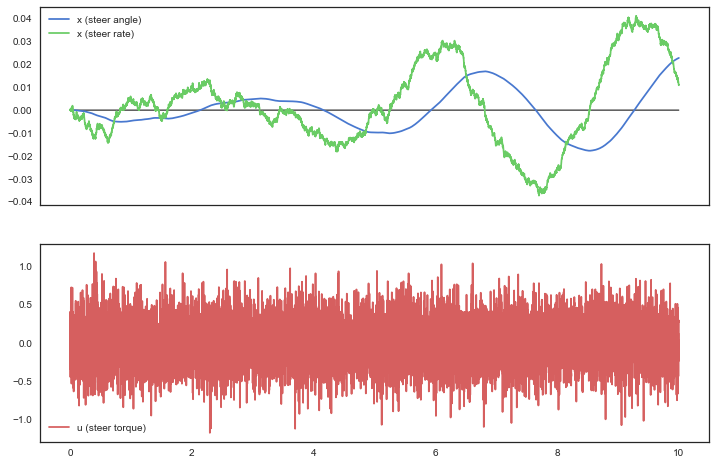

In [5]:
# plot simulated system
colors = sns.color_palette('muted', 6)
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(tout, xout[:, 0], color=colors[0], label='x (steer angle)')
ax[0].plot(tout, xout[:, 1], color=colors[1], label='x (steer rate)')
ax[0].plot(tout, 0*tout, color='black', linewidth=1, zorder=1)
ax[0].legend()
ax[1].plot(tout, u[:, 0], color=colors[2], label='u (steer torque)')
ax[1].plot(tout, 0*tout, color='black', linewidth=1, zorder=1)
ax[1].legend()
plt.show()

In [6]:
# re-simulate system with a Kalman filter
xhat = np.zeros((n, Ad.shape[0], 1))
xhatminus = np.zeros(xhat.shape)
P = np.zeros(tout.shape + Ad.shape)
Pminus = np.zeros(P.shape)
K = np.zeros(tout.shape + tuple(reversed(Cd.shape)))

Q = np.array([
    [1/4*dt**4, 1/2*dt**3],
    [1/2*dt**3,     dt**2]
]) * u.var()
R = np.array([
    [0.0001**2]
]) * (np.pi/180)**2

# measurements are zero since we assume angle is not moving
z = np.zeros((n, 1, 1))

for i in range(n):
    # time update
    # time update state
    xhatminus[i, :] = np.dot(Ad, xhat[i - 1, :]) + np.dot(Bd, u[i - 1, :])
    # time update error covariance
    Pminus[i, :] = np.dot(np.dot(Ad, P[1, :]), Ad.T) + Q
    
    # measurement update
    # measurement update kalman gain
    S = np.dot(np.dot(Cd, Pminus[i, :]), Cd.T) + R
    K[i, :] = np.linalg.lstsq(S, np.dot(Cd, Pminus[i, :].T))[0].T
    # measurement update state
    xhat[i, :] = (xhatminus[i, :] + 
                  np.dot(K[i, :], (z[i, :] - np.dot(Cd, xhatminus[i, :]))))
    P[i, :] = np.dot(np.eye(Ad.shape[0]) - np.dot(K[i, :], Cd), Pminus[i, :])

In [7]:
colors = sns.color_palette('Paired', 8)
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(tout, xout[:, 0], color=colors[0], label='x (steer angle)')
ax[0].plot(tout, xhat[:, 0], color=colors[1], label='xhat (steer angle)')
ax[0].plot(tout, 0*tout, color='black', linewidth=1, zorder=1)
ax[0].legend()
ax[1].plot(tout, xout[:, 1], color=colors[2], label='x (steer rate)')
ax[1].plot(tout, xhat[:, 1], color=colors[3], label='xhat (steer rate)')
ax[1].plot(tout, 0*tout, color='black', linewidth=1, zorder=1)
ax[1].legend()
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
# load data from experimental setup
import re
float_pattern = r'[\-\.0-9]+'
pattern = re.compile(
    r'\[[0-9]+\] kistler:\s+({0}) Nm\s+kollmorgen:\s+({0}) Nm\s+steer:\s+({0}) rad\s+rate:\s+({0}) rad/s'.format(
        float_pattern))

values = []
with open('mass_spring_u_on.log') as f:
    for line in f:
        match = pattern.match(line)
        if match:
            for g in match.groups():
                values.append(float(g))
        else:
            values = []
vals = np.reshape(values, (-1, 4))
u0 = vals[:, :1]
z0 = vals[:, 2:3]

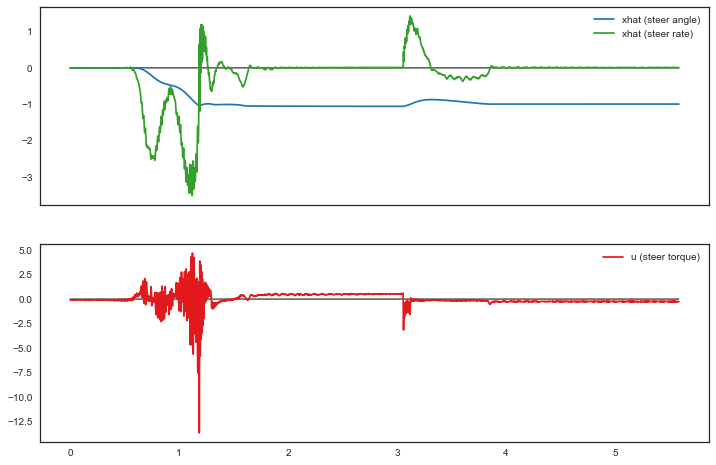

In [9]:
t = np.arange(0, dt*vals.shape[0], dt)
colors = sns.color_palette('Paired', 8)
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(t, vals[:, 2], color=colors[1], label='xhat (steer angle)')
ax[0].plot(t, vals[:, 3], color=colors[3], label='xhat (steer rate)')
ax[0].plot(t, 0*t, color='black', linewidth=1, zorder=1)
ax[0].legend()
ax[1].plot(t, vals[:, 0], color=colors[5], label='u (steer torque)')
ax[1].plot(t, 0*t, color='black', linewidth=1, zorder=1)
ax[1].legend()
plt.show()